# Linear Regression

Simple example of multiple linear regression showing some different strategies for choosing a minimal set of predictor variables (features)

*I hate pandas and I hate coding in notebooks but I ought to do it sometimes*

### First get the Data

In [1]:
##California is too big!
#from sklearn.datasets import fetch_california_housing
#X, y = fetch_california_housing(return_X_y=True, as_frame=True)

##Nothing unethical about using this data 
#- a random blogger objects to attempting to account for racist attitudes towards black residents of 1970s Boston
#- there is a minor technical issue with this variable,
#- as if there aren't minor technical issues with half the data in 'datasets'
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_boston
data = load_boston()
warnings.filterwarnings('once')
import pandas as pd
%matplotlib inline
X = pd.DataFrame(data.data, columns=data.feature_names);
y = pd.DataFrame(data.target, columns=["MedHouseVal"]);
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Let's just look at a subset of the predictor variables to save time

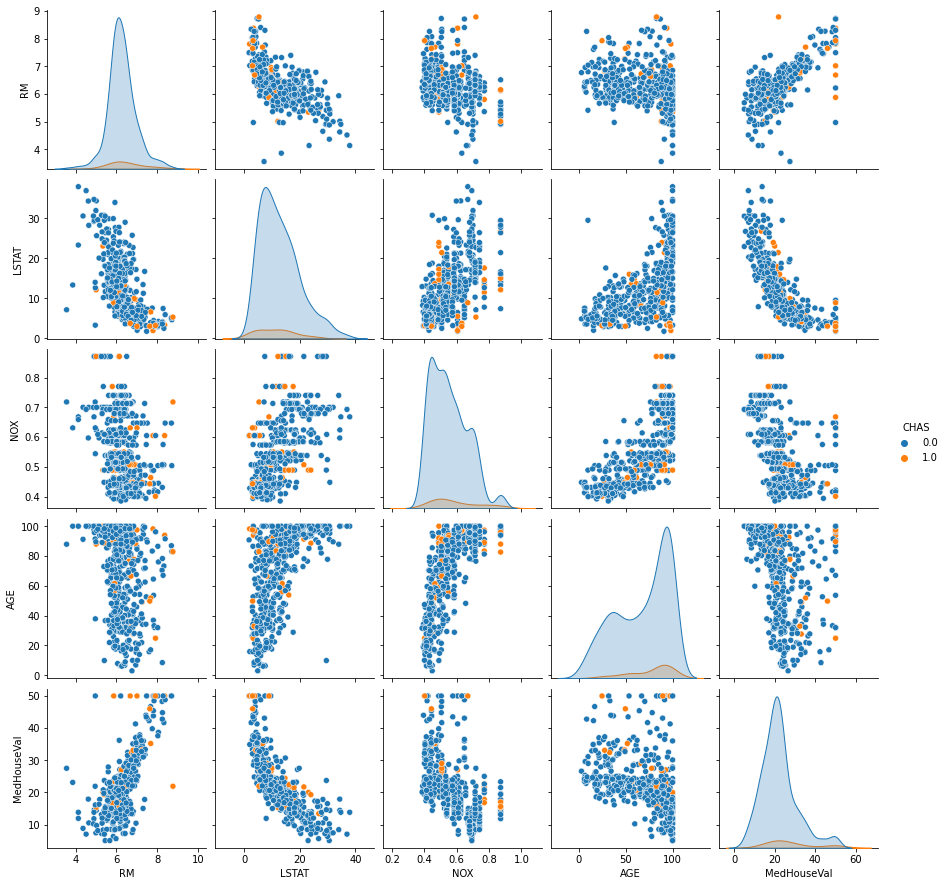

In [2]:
X = X[['RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']]
import seaborn as sns
sns.pairplot(X.merge(y, left_index=True, right_index=True), hue='CHAS')

There are some clear correlations here e.g. LSTAT going up = House prices going down. No obvious patterns to do with living next to the river (CHAS = 1) or not (CHAS = 0).

<AxesSubplot:>

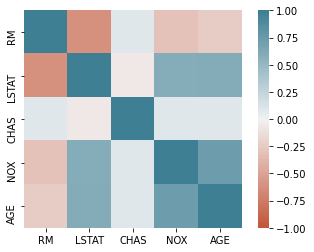

In [3]:
sns.heatmap(
    X.corr(), 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

The correlation matrix tells the same story. The correlation matrix has way less information that the pairplot, 
but pairplot is very difficult to interpret when there are a lot of variables. But we can see for example, that NOX and age are highly correlated, so we might only need one of then in the regression model...

### Simple Linear Regression

In [4]:
import statsmodels.api as sm
X = sm.add_constant(X)  #allows nonzero intercept
model = sm.OLS(y, X).fit()
print( model.summary() )

                            OLS Regression Results                            
Dep. Variable:            MedHouseVal   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     188.8
Date:                Mon, 13 Mar 2023   Prob (F-statistic):          1.14e-112
Time:                        15:15:28   Log-Likelihood:                -1571.9
No. Observations:                 506   AIC:                             3156.
Df Residuals:                     500   BIC:                             3181.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4487      3.344      0.433      0.6

/home/ra414/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


The R-squared is ~0.65. This is pretty good. The table produced here is very important, it tells us which variables are significant. If the p-value (P>|t| column) is small the input is predictive. Alternatively, if the confidence interval does not 'capture' zero, then the input is predictive.

### Model selection: Forward Stepwise Regression

Starting with no covariates, add variables one at a time, trying to minimise the score.
For no particular reason, I am choosing to minimise Bayesian Information. BIC tends to choose models with fewer parameters than AIC.

In [5]:
import numpy as np #for inf

variables = list(X.columns)
min_bic = np.inf;
min_variables = None
forward_variables = []

while len(variables): #while there is something to add
    added = None;     #the variable added this turn (or None)
    for v in variables:
        model = sm.OLS(y, X[ forward_variables + [v] ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = forward_variables + [v]
            min_bic = model.bic
            added = v;

    if len(min_variables) == len(forward_variables): break; #no change in best
    forward_variables = min_variables; #start from best so far for next iteration
    variables.remove(added)            #don't check stuff we've already added!
    
    
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              3206.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:15:28   Log-Likelihood:                         -1573.6
No. Observations:                 506   AIC:                                      3153.
Df Residuals:                     503   BIC:                                      3166.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.8500      0.070     69.049      0.000       4.712       4.988
LSTAT         -0.6504      0.030    -21.633      0.000      -0.709      -0.591
CHAS           4.1309      0.956      4.319      0.000       2.252       6.010
==============================================================================
Omnibus:                      133.127   Durbin-Watson:                   0.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.421
Skew:                           1.234   Prob(JB):                     9.21e-89
Kurtosis:                       6.624   Cond. No.                         61.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model selection: Backwards Stepwise Regression

Starting with all the covariates, remove variables one at a time, trying to minimise the score.

In [6]:
variables = list(X.columns)

backward_variables = variables

model = sm.OLS(y, X[ backward_variables ]).fit()
min_bic = model.bic;
min_variables = backward_variables

while len(variables): #while there is something to add
    print(backward_variables)
    removed = None;     #the variable added this turn (or None)
    for v in backward_variables:
        mvar = [w for w in backward_variables if w!=v]
        model = sm.OLS(y, X[ mvar ]).fit() #fit the model
        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = mvar
            min_bic = model.bic
            removed = v;

    if len(min_variables) == len(backward_variables): break; #no change in best
    backward_variables = min_variables; #start from best so far for next iteration
    variables.remove(removed)            #don't check stuff we've already added!

model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

['const', 'RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']
['RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']
['RM', 'LSTAT', 'CHAS', 'NOX']
['RM', 'LSTAT', 'CHAS']


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              3206.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:15:28   Log-Likelihood:                         -1573.6
No. Observations:                 506   AIC:                                      3153.
Df Residuals:                     503   BIC:                                      3166.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.8500      0.070     69.049      0.000       4.712       4.988
LSTAT         -0.6504      0.030    -21.633      0.000      -0.709      -0.591
CHAS           4.1309      0.956      4.319      0.000       2.252       6.010
==============================================================================
Omnibus:                      133.127   Durbin-Watson:                   0.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.421
Skew:                           1.234   Prob(JB):                     9.21e-89
Kurtosis:                       6.624   Cond. No.                         61.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model selection: Exhaustive Search

Check every possible model. If you have small models and not many parameters this is going to work! But You have to do $2^M$ comparisons where M is the number of parameters. This gets big quickly!

In [7]:
import itertools

variables = list(X.columns)

min_bic = np.inf;
min_variables = None

for r in range(1,len(variables)+1):

    for subset in itertools.combinations(variables, r):
        model = sm.OLS(y, X[ list(subset) ]).fit() #fit the model

        if model.bic < min_bic: #check for improvement, record the new best if there is one
            min_variables = list(subset)
            min_bic = model.bic
    
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              3206.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:15:28   Log-Likelihood:                         -1573.6
No. Observations:                 506   AIC:                                      3153.
Df Residuals:                     503   BIC:                                      3166.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.8500      0.070     69.049      0.000       4.712       4.988
LSTAT         -0.6504      0.030    -21.633      0.000      -0.709      -0.591
CHAS           4.1309      0.956      4.319      0.000       2.252       6.010
==============================================================================
Omnibus:                      133.127   Durbin-Watson:                   0.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              405.421
Skew:                           1.234   Prob(JB):                     9.21e-89
Kurtosis:                       6.624   Cond. No.                         61.3
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model selection: Other Optimisers

The forward and backward procedures are greedy optimisers, greedy search is usually not the best. You are trying to minimise some function (Bayesian information) so try some other __[Optimiser](https://docs.scipy.org/doc/scipy/reference/optimize.html)__ . The optimiser has to be a very general one because computing the derivatives to too hard! 

I'm going to do a trick where I represent a list of variables as a binary number of fixed width so e.g.<br>
['RM', 'LSTAT', 'CHAS', 'NOX', 'AGE']<br>
v = 0 1 0 0 1 1<br>
gives ['LSTAT', 'NOX', 'AGE']

Let's try with more variables and a fancy optimisation algorithm called basin hopping...

In [8]:
from scipy.optimize import basinhopping

X = pd.DataFrame(data.data, columns=data.feature_names);
y = pd.DataFrame(data.target, columns=["MedHouseVal"]);

variables = list(X.columns)

def func(v):
    if sum(v) == 0: return 10e10;
    model = sm.OLS(y, X[ [var for i,var in enumerate(variables) if v[i] > 0.5] ]).fit()
    return model.bic
      
class MyStep:
   def __init__(self, stepsize=0.5):
       self.rng = np.random.default_rng()
       self.M = len(variables) 
   def __call__(self, x):
       idx = self.rng.integers(0,high=self.M)
       x[idx] = 1 - x[idx]
       return x

v0 = np.ones( len(variables), dtype=np.int8 )

minimizer_kwargs = {"method": "BFGS"}
mystep = MyStep()
print("basin_hopping...")
ret = basinhopping(func, v0, minimizer_kwargs=minimizer_kwargs, niter=200, take_step=mystep)

min_variables = [var for i,var in enumerate(variables) if ret.x[i] > 0.5]
model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

basin_hopping...


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              1425.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:15:31   Log-Likelihood:                         -1530.1
No. Observations:                 506   AIC:                                      3076.
Df Residuals:                     498   BIC:                                      3110.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CRIM          -0.0799      0.031     -2.545      0.011      -0.142      -0.018
ZN             0.0437      0.014      3.138      0.002       0.016       0.071
CHAS           2.8766      0.898      3.205      0.001       1.113       4.640
RM             5.5964      0.244     22.926      0.000       5.117       6.076
DIS           -0.7761      0.158     -4.904      0.000      -1.087      -0.465
PTRATIO       -0.4881      0.098     -5.000      0.000      -0.680      -0.296
B              0.0140      0.003      5.404      0.000       0.009       0.019
LSTAT         -0.4853      0.041    -11.761      0.000      -0.566      -0.404
==============================================================================
Omnibus:                      189.204   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1085.081
Skew:                           1.526   Prob(JB):                    2.39e-236
Kurtosis:                       9.492   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Zheng-Loh Model Selection

Simple and it's supposed to work. Zheng and Loh showed that, under appropriate conditions, this method
chooses the true model with probability tending to one as the sample size increases.

1. Fit everything and compute the Wald test statistic for H0 : $c_j = 0$ versus H1 : $c_j = 0$ (I think this is more or less just the t score???)
2. Sort

In [9]:
X = pd.DataFrame(data.data, columns=data.feature_names);
y = pd.DataFrame(data.target, columns=["MedHouseVal"]);

variables = list(X.columns)
model = sm.OLS(y, X[ variables ]).fit()

sigma_2 = model.mse_resid
def zheng_loh_score(v):
    m = sm.OLS(y, X[ v ]).fit()
    #print(m.ssr, len(v)*sigma_2*np.log(m.nobs), len(v), sigma_2, m.nobs)
    return m.ssr + len(v)*m.mse_resid*np.log(m.nobs)

min_zl = np.inf;
min_variables = []
zl_variables = []
for col, t in model.tvalues.abs().sort_values(ascending=False).items(): 
    zl_score = zheng_loh_score(zl_variables + [col])

    if zl_score < min_zl:
        min_zl = zl_score
        min_variables = [v for v in zl_variables] + [col]
        
    zl_variables += [col]

model = sm.OLS(y, X[ min_variables ]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            MedHouseVal   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              1425.
Date:                Mon, 13 Mar 2023   Prob (F-statistic):                        0.00
Time:                        15:15:31   Log-Likelihood:                         -1530.1
No. Observations:                 506   AIC:                                      3076.
Df Residuals:                     498   BIC:                                      3110.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             5.5964      0.244     22.926      0.000       5.117       6.076
LSTAT         -0.4853      0.041    -11.761      0.000      -0.566      -0.404
B              0.0140      0.003      5.404      0.000       0.009       0.019
DIS           -0.7761      0.158     -4.904      0.000      -1.087      -0.465
PTRATIO       -0.4881      0.098     -5.000      0.000      -0.680      -0.296
ZN             0.0437      0.014      3.138      0.002       0.016       0.071
CHAS           2.8766      0.898      3.205      0.001       1.113       4.640
CRIM          -0.0799      0.031     -2.545      0.011      -0.142      -0.018
==============================================================================
Omnibus:                      189.204   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1085.081
Skew:                           1.526   Prob(JB):                    2.39e-236
Kurtosis:                       9.492   Cond. No.                     1.49e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Finally: 

The Zheng-Loh has good theoretical properties, the other approaches are fine too. Sometimes optimising BIC is good to reduce the number of params as much as possible.